# 目的
- http://chainercv.readthedocs.io/en/stable/tutorial/sliceable.html
- chainerCVの上記URLのチュートリアルを実行
- ChainerCVのデータセットを扱う

In [1]:
# VOCBboxDataset supports sliceable feature
from chainercv.datasets import VOCBboxDataset
dataset = VOCBboxDataset()


/home/tokita/.pyenv/versions/anaconda2-4.4.0/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# keys returns the names of data
print(dataset.keys)  # ('img', 'bbox', 'label')

('img', 'bbox', 'label')


In [3]:
# indexを指定してデータを取得
img, bbox, label = dataset[0]

In [4]:
print(len(dataset.ids))

5717


In [5]:
print(img.shape)

(3, 442, 500)


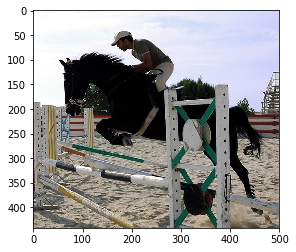

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow((img/255.0).transpose(1,2,0))

In [7]:
print(bbox)

[[ 86.  52. 419. 470.]
 [ 43. 157. 166. 288.]]


In [8]:
from chainercv.datasets import voc_bbox_label_names
print([voc_bbox_label_names[i] for i in label])

['horse', 'person']


In [9]:
# sliceメソッドでデータを切り出す
view = dataset.slice[:100]
print(len(view))  # 100
print(view.keys)

100
('img', 'bbox', 'label')


('img', 'label')
5717
['dog']


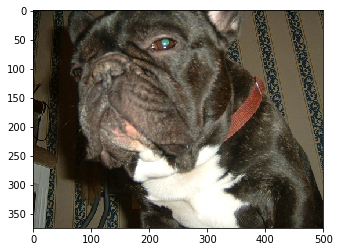

In [10]:
# get a view of image and label
view = dataset.slice[:, ('img', 'label')]
# the view also supports sliceable, so that we can call keys
print(view.keys)  # ('img', 'label')
print(len(view))
# we can get an example by []
img, label = view[10]
plt.imshow((img/255.0).transpose(1,2,0))
print([voc_bbox_label_names[i] for i in label])

slice()メソッドは、dataのロードを伴わないので効率的。 　

slice有無の速度比較

In [11]:
# import time

# from chainercv.datasets import VOCBboxDataset
# from chainercv.datasets import voc_bbox_label_names

# dataset = VOCBboxDataset()
# dog_lb = voc_bbox_label_names.index('dog') # dogのid

# # with slice
# t = time.time()
# count = 0
# # labelのviewを作成
# view = dataset.slice[:, 'label']
# for i in range(len(view)):
#     # we can focus on label
#     label = view[i] # i番目のindexのラベル
#     if dog_lb in label:
#         count += 1
# print('w/ slice: {} secs'.format(time.time() - t))
# print('{} images contain dogs'.format(count))
# print()

# # without slice
# t = time.time()
# count = 0
# for i in range(len(dataset)):
#     # img and bbox are loaded but not needed
#     img, bbox, label = dataset[i]
#     if dog_lb in label:
#         count += 1
# print('w/o slice: {} secs'.format(time.time() - t))
# print('{} images contain dogs'.format(count))
# print()

# Concatenate and transform

In [12]:
from chainercv.chainer_experimental.datasets.sliceable import ConcatenatedDataset
from chainercv.chainer_experimental.datasets.sliceable import TransformDataset
from chainercv.datasets import VOCBboxDataset
from chainercv.datasets import voc_bbox_label_names

dataset_07 = VOCBboxDataset(year='2007')
print('07:', dataset_07.keys, len(dataset_07))  # 07: ('img', 'bbox', 'label') 2501

dataset_12 = VOCBboxDataset(year='2012')
print('12:', dataset_12.keys, len(dataset_12))  # 12: ('img', 'bbox', 'label') 5717

# concatenate
dataset_0712 = ConcatenatedDataset(dataset_07, dataset_12)
print('0712:', dataset_0712.keys, len(dataset_0712))  # 0712: ('img', 'bbox', 'label') 8218

# transform
def transform(in_data):
    img, bbox, label = in_data

    dog_lb = voc_bbox_label_names.index('dog')
    bbox_dog = bbox[label == dog_lb]

    return img, bbox_dog

# we need to specify the names of data that the transform function returns
dataset_0712_dog = TransformDataset(dataset_0712, ('img', 'bbox_dog'), transform)
print('0712_dog:', dataset_0712_dog.keys, len(dataset_0712_dog))  # 0712_dog: ('img', 'bbox_dog') 8218

07: ('img', 'bbox', 'label') 2501
12: ('img', 'bbox', 'label') 5717
0712: ('img', 'bbox', 'label') 8218
0712_dog: ('img', 'bbox_dog') 8218


In [13]:
dataset_0712_dog.keys

('img', 'bbox_dog')

(3, 333, 500)
(0, 4)


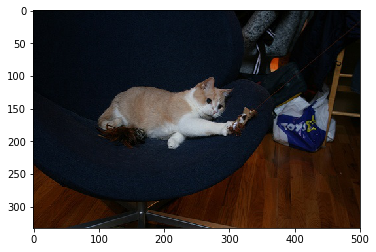

In [14]:
img, bbox_dog = dataset_0712_dog[10]
plt.imshow((img/255.0).transpose(1,2,0))
print(img.shape)
print(bbox_dog.shape)

# Make your own dataset

In [15]:
import numpy as np

from chainercv.chainer_experimental.datasets.sliceable import GetterDataset
from chainercv.utils import generate_random_bbox

class SampleBboxDataset(GetterDataset):
    def __init__(self):
        super(SampleBboxDataset, self).__init__()

        # register getter method for image
        self.add_getter('img', self.get_image)
        # register getter method for bbox and label
        self.add_getter(('bbox', 'label'), self.get_annotation)

    def __len__(self):
        return 20

    def get_image(self, i):
        print('get_image({})'.format(i))
        # generate dummy image
        img = np.random.uniform(0, 255, size=(3, 224, 224)).astype(np.float32)
        return img

    def get_annotation(self, i):
        print('get_annotation({})'.format(i))
        # generate dummy annotations
        bbox = generate_random_bbox(10, (224, 224), 10, 224)
        label = np.random.randint(0, 9, size=10).astype(np.int32)
        return bbox, label

# ダミーの画像とアノテーションBBoxデータを生成するクラス
dataset = SampleBboxDataset()
img, bbox, label = dataset[0]  # get_image(0) and get_annotation(0)

view = dataset.slice[:, 'label']
label = view[1]  # get_annotation(1)

get_image(0)
get_annotation(0)
get_annotation(1)


In [16]:
dataset[0]

get_image(0)
get_annotation(0)


(array([[[167.06207   , 196.61469   , 225.87437   , ..., 113.78757   ,
          175.59161   ,  16.03846   ],
         [111.21818   , 153.17361   , 223.38808   , ..., 164.20076   ,
          237.31755   ,  75.33374   ],
         [ 44.87439   , 147.88872   , 142.49438   , ..., 250.52905   ,
            5.009702  ,  60.644173  ],
         ...,
         [189.03958   ,  12.691817  , 237.30318   , ..., 110.55843   ,
          220.36745   , 198.50249   ],
         [126.183464  ,  23.87883   , 236.50461   , ..., 136.69162   ,
           73.628654  , 122.74922   ],
         [252.40921   , 118.00121   ,  45.29728   , ..., 109.85684   ,
          129.48824   , 214.37218   ]],
 
        [[149.36192   , 244.39725   ,  44.042927  , ...,  41.110325  ,
          184.98041   , 196.60318   ],
         [138.83032   , 147.91383   , 100.196495  , ...,  36.249367  ,
          117.86916   ,  14.896338  ],
         [110.48181   ,  63.0937    , 111.032616  , ..., 235.78998   ,
           99.838615  , 102.2755

arrayデータがあれば、TupleDatasetメソッドでデータを作れる

In [17]:
import numpy as np

from chainercv.chainer_experimental.datasets.sliceable import TupleDataset
from chainercv.utils import generate_random_bbox

n = 20
imgs = np.random.uniform(0, 255, size=(n, 3, 224, 224)).astype(np.float32)
bboxes = [generate_random_bbox(10, (224, 224), 10, 224) for _ in range(n)]
labels = np.random.randint(0, 9, size=(n, 10)).astype(np.int32)

dataset = TupleDataset(('img', imgs), ('bbox', bboxes), ('label', labels))

print(dataset.keys)  # ('img', 'bbox', 'label')
view = dataset.slice[:, 'label']
label = view[1]

('img', 'bbox', 'label')


In [18]:
imgs.shape

(20, 3, 224, 224)

In [19]:
print(len(bboxes))
print(bboxes[0].shape)

20
(10, 4)


In [20]:
bboxes

[array([[  0.      ,   0.      ,  99.16522 , 210.17073 ],
        [  0.      ,   0.      , 132.94926 , 182.59811 ],
        [  0.      ,   0.      , 144.03763 , 119.48821 ],
        [  0.      ,   0.      , 140.5527  , 188.63297 ],
        [  0.      ,   0.      ,  41.689457,  73.12413 ],
        [  0.      ,   0.      ,  62.987244, 125.56017 ],
        [  0.      ,   0.      ,  45.65611 , 157.26715 ],
        [  0.      ,   0.      ,  20.917824, 185.05353 ],
        [  0.      ,   0.      , 201.87624 ,  31.42343 ],
        [  0.      ,   0.      , 175.06508 ,  17.808453]], dtype=float32),
 array([[  0.      ,   0.      , 182.56812 , 193.45201 ],
        [  0.      ,   0.      ,  40.57138 ,  31.210152],
        [  0.      ,   0.      , 217.64336 , 191.06305 ],
        [  0.      ,   0.      , 108.11647 , 196.28217 ],
        [  0.      ,   0.      ,  75.98963 , 156.79597 ],
        [  0.      ,   0.      , 173.81895 ,  19.52315 ],
        [  0.      ,   0.      ,  24.28207 ,  96.42018 

In [21]:
labels

array([[1, 1, 4, 6, 5, 7, 4, 4, 7, 2],
       [6, 3, 3, 1, 6, 4, 1, 6, 0, 3],
       [2, 8, 7, 0, 3, 5, 8, 4, 7, 6],
       [6, 5, 1, 2, 7, 3, 1, 7, 6, 7],
       [0, 0, 1, 3, 4, 7, 2, 7, 6, 2],
       [2, 8, 1, 7, 0, 4, 1, 8, 4, 7],
       [2, 3, 2, 5, 7, 3, 1, 1, 6, 1],
       [2, 4, 1, 7, 7, 1, 0, 0, 6, 2],
       [0, 8, 1, 5, 6, 1, 4, 6, 4, 3],
       [3, 0, 3, 3, 0, 6, 2, 2, 1, 5],
       [8, 2, 6, 4, 1, 7, 3, 6, 5, 2],
       [5, 5, 1, 0, 2, 4, 7, 3, 4, 3],
       [3, 0, 4, 2, 1, 1, 3, 7, 5, 5],
       [1, 1, 2, 0, 4, 1, 1, 7, 8, 4],
       [8, 1, 4, 4, 8, 5, 8, 3, 2, 7],
       [2, 4, 0, 1, 4, 4, 6, 6, 8, 3],
       [0, 6, 6, 6, 6, 0, 2, 7, 8, 3],
       [3, 8, 1, 3, 8, 8, 0, 8, 0, 3],
       [2, 0, 2, 2, 2, 3, 4, 0, 8, 4],
       [1, 6, 4, 4, 0, 5, 0, 3, 1, 1]], dtype=int32)

In [22]:
dataset[0]

(array([[[216.35858   , 252.97623   , 117.575806  , ...,  81.09788   ,
           78.12191   , 244.09998   ],
         [  0.87869537, 237.74243   , 250.1701    , ...,  60.22855   ,
          209.80342   ,  67.34312   ],
         [ 15.833999  , 152.46246   , 191.85349   , ..., 104.990005  ,
          192.57594   , 142.68845   ],
         ...,
         [ 93.21166   , 129.44112   , 182.73018   , ..., 214.94167   ,
          184.81303   , 223.14297   ],
         [147.45491   , 115.99648   , 198.14796   , ..., 150.199     ,
          110.57174   , 146.3189    ],
         [227.81824   , 184.49434   , 230.40561   , ..., 138.22954   ,
          166.31532   ,   7.514982  ]],
 
        [[188.48659   , 213.64314   , 188.78168   , ..., 115.587074  ,
            4.749599  , 121.19545   ],
         [218.93538   ,  68.38694   ,   4.7019367 , ...,  82.84954   ,
           13.134695  ,  98.85734   ],
         [204.03273   , 254.63214   ,  56.366478  , ...,  65.79186   ,
           43.147488  , 174.7671